# Goal

Jacobo de la Cuesta-Zuluaga, July 2018.

# Init

In [62]:
library(tidyverse)
library(reshape2)
library(ape)
library(phylobase)
library(phangorn)
library(phylosignal)
library(geiger)
library(caret)
library(furrr)
library(micropan)
library(cowplot)
library(phytools)

Loading required package: maps

Attaching package: ‘maps’

The following object is masked from ‘package:purrr’:

    map



In [28]:
# R misc functions
source("/ebio/abt3_projects/vadinCA11/data/V11/R_utils/utils.R")

In [29]:
# Load itol scripts
itol_dir = "/ebio/abt3_projects/vadinCA11/data/V11/itol"
itol_code = file.path(itol_dir, "itol.R") 
source(file = itol_code)

# Var

In [30]:
# Load phylogenomic tree
#phylo_tree_file = file.path("/ebio/abt3_projects/vadinCA11/data/V11/anvio_output/phylogenomic_tree.txt")
phylo_tree_file = file.path("/ebio/abt3_projects/vadinCA11/data/V11/phylophlan/trees/RAxML_bipartitions.methanomassilii.tre")
phylogenomic_tree_raw = read.tree(phylo_tree_file)
phylogenomic_tree_raw$node.label = c() # solves the "Labels are not unique" message


# Root tree and remove root for downstream analyses
outgroup_clades = c("GCA_900090055", "GCA_000195915", "GCA_900176435", "GCA_000152265", "GCA_001402945")
phylogenomic_tree_raw = phylogenomic_tree_raw %>% root(., outgroup = outgroup_clades)
phylogenomic_tree = phylogenomic_tree_raw %>% drop.tip(., outgroup_clades)


# Load metadata
raw_methanomassilii_data = "/ebio/abt3_projects/vadinCA11/data/V11/assemblies_metadata/Assembly_metadata_curated.txt" %>%
    read_tsv %>%
    as.data.frame %>%
    rename("Label" = "X1") %>% 
    mutate_at(vars(starts_with("source"), location), factor)

ELPs_table = "/ebio/abt3_projects/vadinCA11/data/V11/itol/ELPs.tsv" %>%
    read_tsv() %>%
    as.data.frame

# Load Annotated cluster table
Annot_clusters = "/ebio/abt3_projects/vadinCA11/data/V11/cluster_annot/Gene_cluster_annots.tsv" %>%
    read_delim(delim = "\t")


# Import Mash ANI table
Mdb = read.csv("/ebio/abt3_projects/vadinCA11/data/V11/drep/data_tables/Mdb.csv")

# Organize label names
# It is important to import them as char and not as factor
label_table = read.table("/ebio/abt3_projects/vadinCA11/data/V11/anvio_output/external_genomes.txt",
                       header = T, sep = "\t", as.is = T)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_character(),
  Assembly = col_character(),
  GC = col_double(),
  Len = col_double(),
  Genes = col_double(),
  source_1 = col_character(),
  source_2 = col_character(),
  source_3 = col_character(),
  source_manual = col_character(),
  location = col_character()
)
Parsed with column specification:
cols(
  Assembly = col_character(),
  ALP = col_double(),
  ANK = col_double(),
  FN3 = col_double(),
  Ig_like = col_double(),
  List_Bact = col_double(),
  LRR = col_double(),
  Sel1 = col_double(),
  TPR = col_double(),
  YadA = col_double()
)
Parsed with column specification:
cols(
  .default = col_double(),
  MSA = col_character(),
  Gene_Name = col_character(),
  Annotation = col_character(),
  NOG = col_character(),
  COG_1 = col_character(),
  eggNOG_annot = col_character(),
  Interpro_accession = col_character(),
  Interpro_annot = col_character()
)
See spec(...) for full co

In [31]:
# Plots out dir
plots_dir = "/ebio/abt3_projects/vadinCA11/data/V11/out_plots/"

In [32]:
# Add ELP data to Methanomassilii table
methanomassilii_data = raw_methanomassilii_data %>% 
    left_join(., ELPs_table, by = "Assembly") %>%
    column_to_rownames("Assembly") 

methanomassilii_data %>% dfhead

[1] 72 18


,Label,GC,Len,Genes,source_1,source_2,source_3,source_manual,location,ALP,ANK,FN3,Ig_like,List_Bact,LRR,Sel1,TPR,YadA
,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GCA_000300255,Candidatus_Methanomethylophilus_alvus_Mx1201,0.5559482,1666795,1636,Host-associated,Feces,Human,Human_feces,NA,0,0,0,0,6,1,28,37,0
GCA_000308215,Methanomassiliicoccus_luminyensis_B10,0.6047886,2620233,2607,Host-associated,Feces,Human,Human_feces,NA,2,0,5,1,2,5,1,11,0
GCA_000404225,Candidatus_Methanomassiliicoccus_intestinalis_Issoire_Mx1,0.4125543,1931651,1855,Host-associated,Feces,Human,Human_feces,NA,1,1,0,1,26,7,6,15,0


In [33]:
# COG relabund of core per clade
cores_COG_relabund = "/ebio/abt3_projects/vadinCA11/data/V11/COG_tables/COG_cores_relabund.tsv" %>%
    read_tsv() %>%
    as.data.frame

cores_COG_relabund %>% head


# COG relabund of core per clade
COG_cores_clade = "/ebio/abt3_projects/vadinCA11/data/V11/COG_tables/COG_cores_clade.tsv" %>%
    read_tsv() %>%
    as.data.frame

COG_cores_clade %>% dfhead

Parsed with column specification:
cols(
  .default = col_double(),
  Genome = col_character(),
  clade = col_character()
)
See spec(...) for full column specifications.


Genome,B,C,D,E,F,G,H,I,J,⋯,O,P,Q,S,T,U,V,X,Z,clade
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GCA_000300255,0.0000000000,0.07718121,0.006711409,0.09955257,0.04362416,0.03691275,0.07941834,0.01118568,0.15212528,⋯,0.04362416,0.04138702,0.001118568,0.1554810,0.012304251,0.008948546,0.03467562,0.07494407,0,HA
GCA_000308215,0.0007241130,0.09123823,0.009413469,0.09413469,0.03403331,0.02606807,0.05648081,0.01230992,0.09847936,⋯,0.04127444,0.06517017,0.002896452,0.1585807,0.021723389,0.006517017,0.04996379,0.10282404,0,FL
GCA_000404225,0.0000000000,0.11948529,0.011029412,0.06985294,0.05698529,0.02941176,0.06250000,0.02022059,0.16360294,⋯,0.04963235,0.05147059,0.000000000,0.1268382,0.003676471,0.009191176,0.06617647,0.06801471,0,FL
GCA_000800805,0.0000000000,0.07808564,0.005037783,0.09823678,0.05163728,0.03400504,0.07052897,0.01259446,0.17002519,⋯,0.04534005,0.03400504,0.001259446,0.1561713,0.006297229,0.010075567,0.02518892,0.07934509,0,HA
GCA_001421175,0.0000000000,0.07660021,0.008394544,0.10073452,0.04826863,0.03462749,0.08079748,0.01154250,0.15215110,⋯,0.04826863,0.03357817,0.001049318,0.1469045,0.008394544,0.009443861,0.03147954,0.07764953,0,HA
GCA_001421185,0.0007173601,0.09182209,0.012195122,0.10258250,0.03658537,0.02941176,0.05954089,0.01362984,0.09827834,⋯,0.04160689,0.04806313,0.003586801,0.1535151,0.029411765,0.005021521,0.03443329,0.10473458,0,FL


Parsed with column specification:
cols(
  COG_1 = col_character(),
  n = col_double(),
  Proportion = col_double(),
  Clade = col_character()
)


[1] 82  4


COG_1,n,Proportion,Clade
<chr>,<dbl>,<dbl>,<chr>
B,6,0.2782931,EX
C,121,5.6122449,EX
D,22,1.0204082,EX


# Clean and order tables

## Mash-ANI dendrogram

In [34]:
# Mdb is in long format, needs to be cast
Mash_cast = dcast(genome1 ~ genome2, data = Mdb, value.var = "dist")

# Add genome name column as rownames and convert to distance matrix
row.names(Mash_cast) = Mash_cast[, 1]
Mash_cast = Mash_cast[, -1]
Mash_dist = Mash_cast %>% as.dist()

# Note that the y-axis plots the distance, need to fi
Mash_hclust = Mash_dist %>% hclust(., method = "average")

label_table$contigs_db_path = label_table$contigs_db_path %>% 
  as.vector %>% lapply(. , function(x) basename(x) %>% strsplit(., ".db", fixed = T)) %>%
  unlist

Mash_labels = Mash_hclust$labels %>% strsplit(., "\\..*", perl =  T) %>% unlist

ord_label_table = label_table[match(Mash_labels,label_table$contigs_db_path), ]

Mash_hclust$labels = ord_label_table$name %>% as.character()

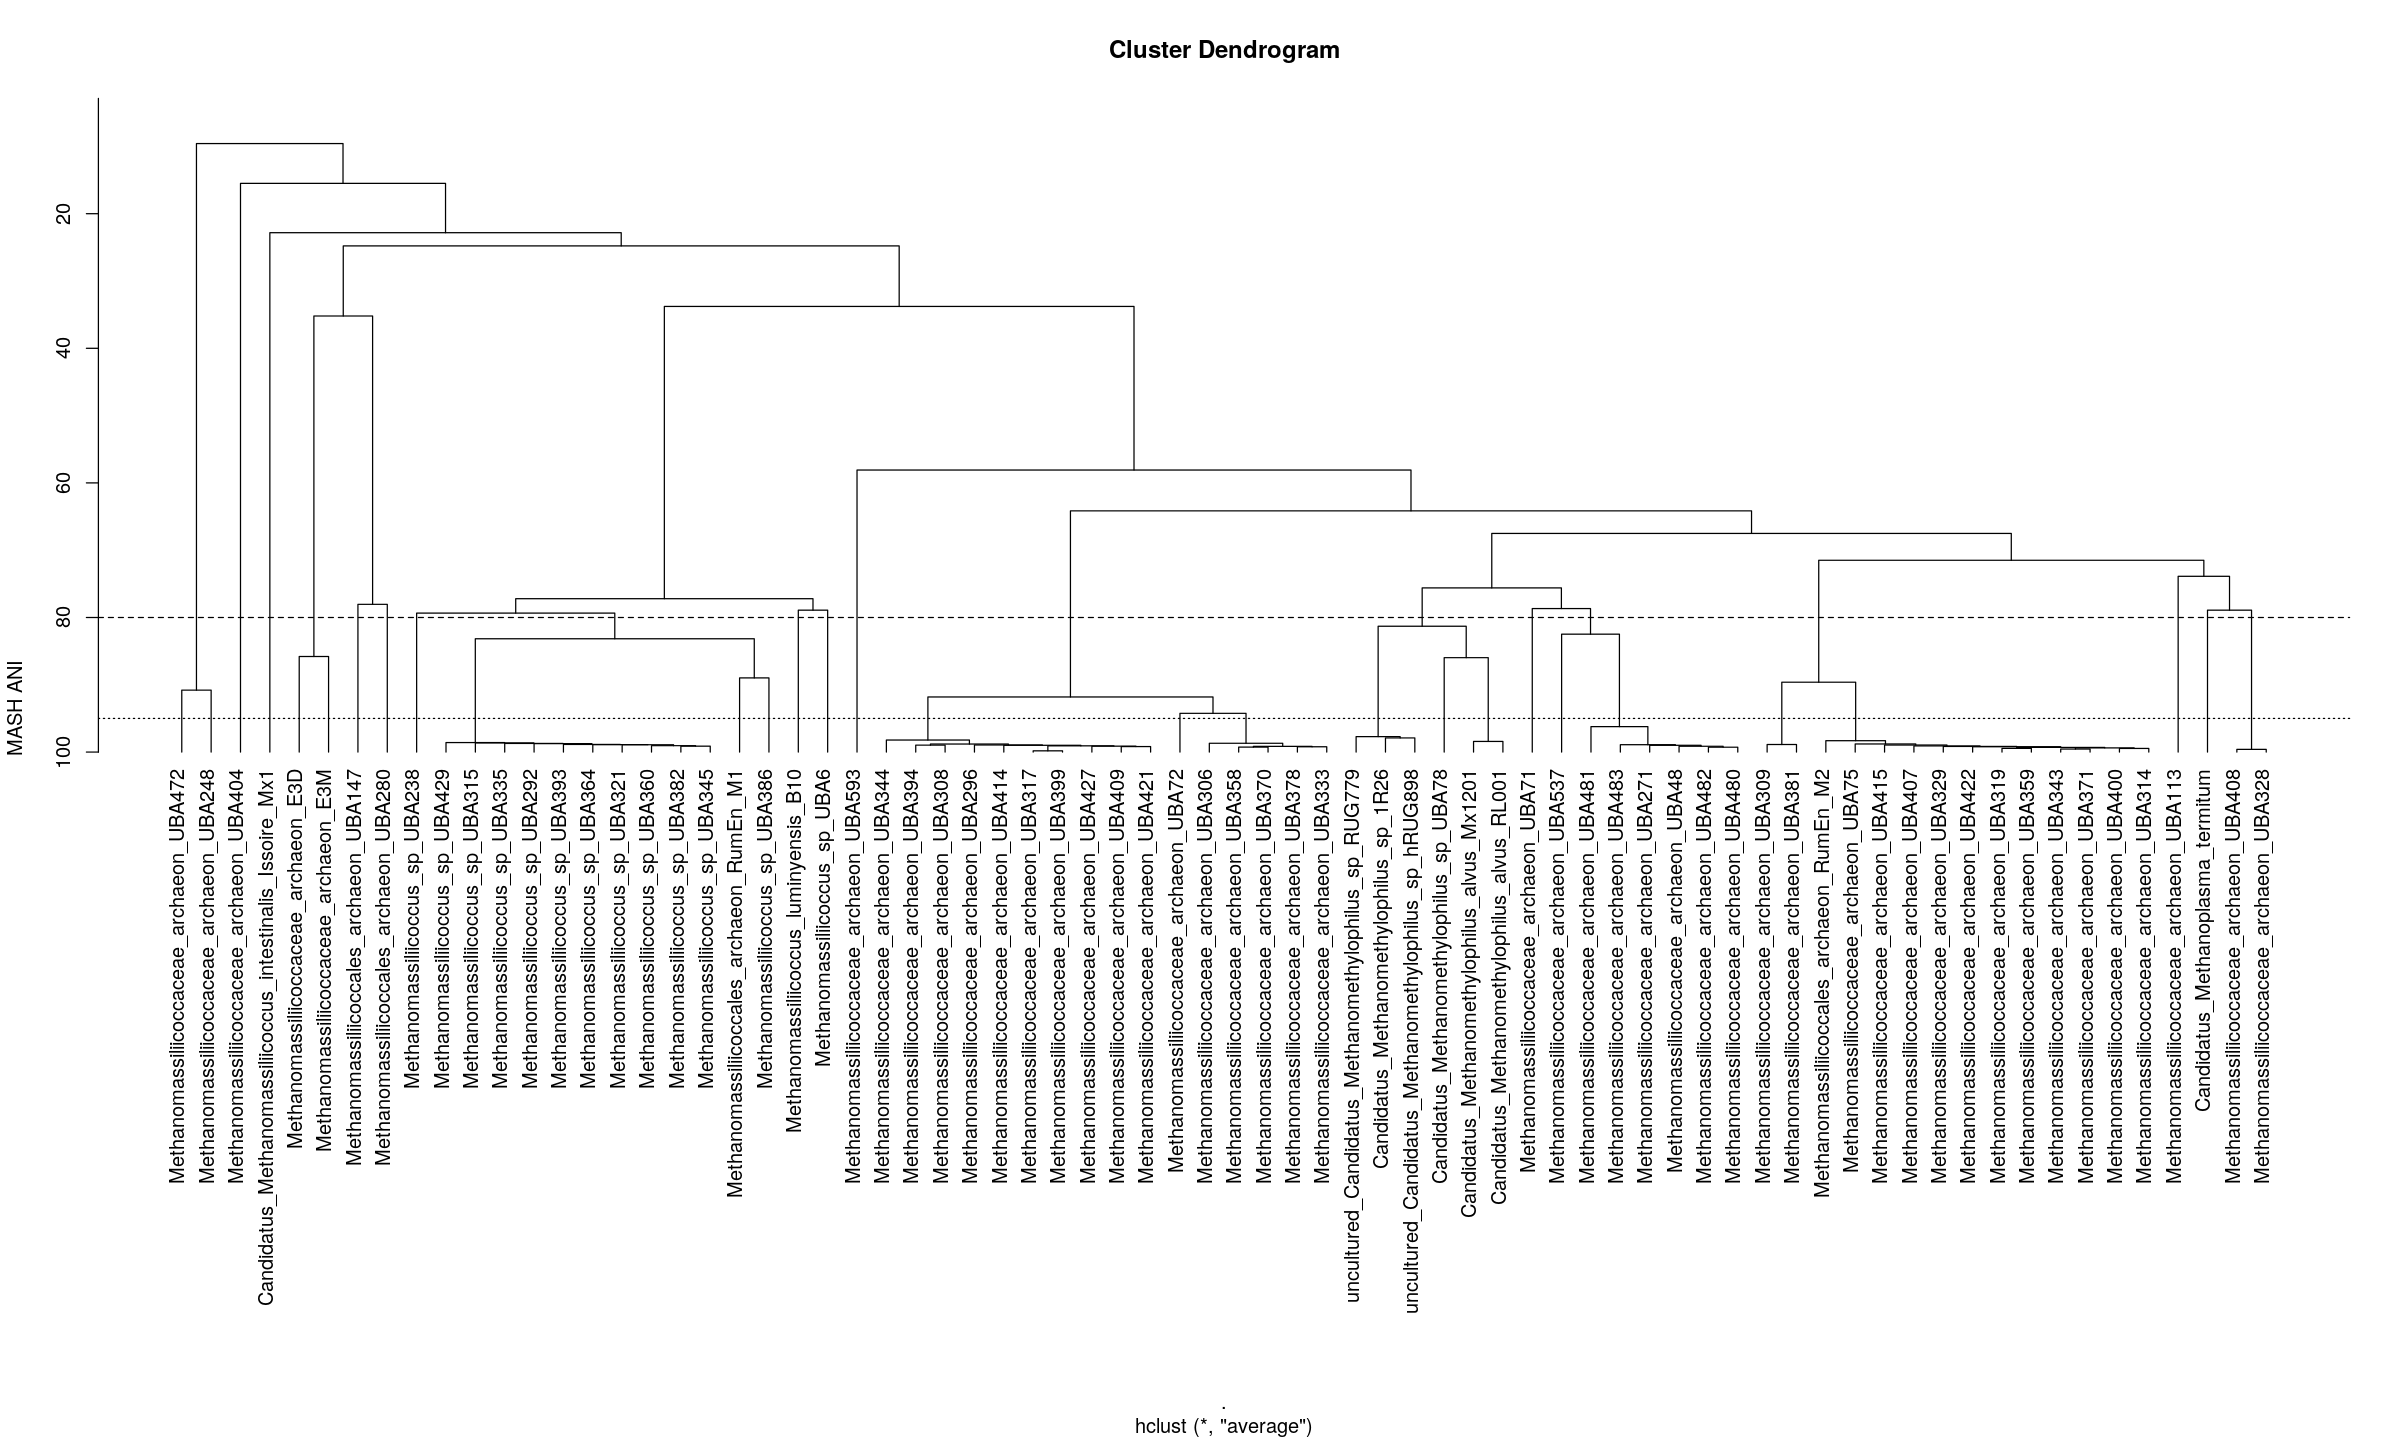

In [35]:
# Set options and plot
options(repr.plot.width = 20, repr.plot.height = 12)
Mash_hclust %>% plot(., hang = -1, y = "MASH ANI", yaxt="n")

# Invert the labels in the y-axis 
# From 100% to 0% identity
axis(2, at = seq(0,1,0.2), labels = seq(100, 0, -20))
abline(h = 0.2, lty = 2) # 80% ANI Genus cutoff
abline(h = 0.05, lty = 3) # 95% ANI species cutoff

## Metadata 

In [36]:
# GC content as percentage and genome length in Kb
methanomassilii_data$GC = methanomassilii_data$GC*100
methanomassilii_data$Len = methanomassilii_data$Len/1000
methanomassilii_data$source_1 = methanomassilii_data$source_1 %>% factor() #%>% as.numeric()
methanomassilii_data$source_2 = methanomassilii_data$source_2 %>% factor()
methanomassilii_data$source_3 = methanomassilii_data$source_3 %>% factor()
methanomassilii_data$location = methanomassilii_data$location %>% factor()

# single ALP column as sum of all ALP NOGs
ALP_NOGs =  c("NOG_COG3420", "NOG_COG3210", "NOG_0ZWMD", "NOG_COG4870", "NOG_COG1305", 
    "NOG_0ZJ40", "NOG_COG5295", "NOG_1079A", "NOG_0XNUF", "NOG_12BI9", "NOG_0ZW39", 
    "NOG_0YRJ4", "NOG_COG1520", "NOG_0XQ8S", "NOG_0YYP1", "NOG_COG3291", "NOG_1285U")



# Add species name and order the data 
# methanomassilii_data = methanomassilii_data[match(ord_label_table$contigs_db_path,
#                                                   methanomassilii_data$Assembly),]

### Create table with clade, source and ELP information

In [37]:
# Add Clade data to the metadata table and save
# Host Associated, Free Living and EXternal
HA_clade = c("GCA_002504405", "GCA_002506175", "GCA_002504495", "GCA_002506425", 
             "GCA_002503925", "GCA_002494805", "GCA_002498545", "GCA_002497475", 
             "GCA_002508595", "GCA_000800805", "GCA_002506905", "GCA_002496945", 
             "GCA_002495325", "GCA_002503545", "GCA_000300255", "V11_RL001", 
             "GCA_001481295", "GCA_900313075", "GCA_900314325", "GCA_002505245", 
             "GCA_002503785", "GCA_002506865", "GCA_002502545", "GCA_002509415", 
             "GCA_002498765", "GCA_002498785", "GCA_001421175", "GCA_002502965", 
             "GCA_002497155", "GCA_002509425", "GCA_002496785", "GCA_002505275", 
             "GCA_002506325", "GCA_002498605", "GCA_002509405", "GCA_002505345", 
             "GCA_002504645", "GCA_002502765", "GCA_002495665", "GCA_002506565", 
             "GCA_002508625", "GCA_002498425", "GCA_002498805", "GCA_002502925", 
             "GCA_002502465", "GCA_002498365", "GCA_002506995", "GCA_002494585", 
             "GCA_002509465", "GCA_002495495")

FL_clade = c("GCA_003153895", "GCA_003135935", "GCA_002506985", "GCA_002497075", 
             "GCA_000404225", "GCA_000308215", "GCA_002508545", "GCA_002494705", 
             "GCA_001421185", "GCA_002498285", "GCA_002495585", "GCA_002497995", 
             "GCA_002504525", "GCA_002496345", "GCA_002508585", "GCA_002508555", 
             "GCA_002502005", "GCA_002503495", "GCA_002505225", "GCA_002503645")

EX_clade = c("GCA_002496385", "GCA_002499085")

df_HA = data.frame(Assembly = HA_clade, 
                   clade = gsub(pattern = ".*", replacement = "HA", x = HA_clade, perl = T))
df_FL = data.frame(Assembly = FL_clade, 
                   clade = gsub(pattern = ".*", replacement = "FL", x = FL_clade, perl = T))
df_EX = data.frame(Assembly = EX_clade, 
                   clade = gsub(pattern = ".*", replacement = "EX", x = EX_clade, perl = T))

df_Clade = bind_rows(df_HA, df_FL, df_EX)


traits_df = methanomassilii_data %>% 
    #select(traits, source_1, source_2, source_3) %>%
    rownames_to_column(var = "Assembly") %>%
    left_join(df_Clade, by = "Assembly") %>%
    mutate(clade = factor(clade))

traits_df %>% dfhead

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

[1] 72 20


Assembly,Label,GC,Len,Genes,source_1,source_2,source_3,source_manual,location,ALP,ANK,FN3,Ig_like,List_Bact,LRR,Sel1,TPR,YadA,clade
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GCA_000300255,Candidatus_Methanomethylophilus_alvus_Mx1201,55.59482,1666.795,1636,Host-associated,Feces,Human,Human_feces,NA,0,0,0,0,6,1,28,37,0,HA
GCA_000308215,Methanomassiliicoccus_luminyensis_B10,60.47886,2620.233,2607,Host-associated,Feces,Human,Human_feces,NA,2,0,5,1,2,5,1,11,0,FL
GCA_000404225,Candidatus_Methanomassiliicoccus_intestinalis_Issoire_Mx1,41.25543,1931.651,1855,Host-associated,Feces,Human,Human_feces,NA,1,1,0,1,26,7,6,15,0,FL


# Phylogenetic Signal

## Using marker protein tree

### Moran's I

Recall that the eukaryote-like proteins I used were:

* Adhesin-like proteins (ALPs): `Parallel beta-helix repeat`
* Sel1 containing proteins (Sel1): `Sel1`
* Listeria-Bacteroides repeat containing proteins (List-Bact): `Listeria-Bacteroides`
* Tetratrico peptide repeats (TPRs): `Tetratrico` 
* Ankyrin repeats (ANKs): `Ankyrin`
* Leucine-rich repeats (LRRs): `Leucine-rich`
* Fibronectin type III (fn3) domains: `Fibronectin type III`
* Laminin G domain: `Laminin G`
* Bacterial Ig-like domains: `Ig-like`
* YadA-like domain (Yersinia adhesin A): `YadA` 
* TadE-like domain: `TadE` 
* Invasion protein B (ialB): `Invasion protein B`

In [38]:
# Create new object with tree and metadata
traits = c("GC","Len","Genes", "ALP", "ANK", "FN3", "Ig_like", 
           "List_Bact", "LRR", "Sel1", "TPR", "YadA")

methanomassilii_p4d = phylo4d(x = phylogenomic_tree, 
                              methanomassilii_data[, traits])

# Calculate Moran's I
methanomassilii_moran = phyloSignal(methanomassilii_p4d, method = "I")
methanomassilii_moran = cbind(methanomassilii_moran$stat,
                              methanomassilii_moran$pvalue)
colnames(methanomassilii_moran) = c("Moran_I", "p_value")

# Adjust p-values for multiple comparisons
methanomassilii_moran = methanomassilii_moran %>%
    rownames_to_column("Variable") %>%
    mutate(p_adjust = p.adjust(p_value, method = "fdr"))

methanomassilii_moran %>% mutate_if(is.numeric, function(x) round(x, 3))

Variable,Moran_I,p_value,p_adjust
<chr>,<dbl>,<dbl>,<dbl>
GC,0.211,0.001,0.002
Len,0.392,0.001,0.002
Genes,0.416,0.001,0.002
ALP,0.183,0.001,0.002
ANK,0.003,0.133,0.145
FN3,0.107,0.007,0.008
Ig_like,0.097,0.004,0.005
List_Bact,0.146,0.001,0.002
LRR,0.107,0.002,0.003


## Phylogenetic ANOVA on genome length, gene count and GC content

In [39]:
Features_df = traits_df %>%
    select(Assembly, GC, Len, Genes, clade)

Features_df %>% dfhead

Feature_traits = c("GC", "Len", "Genes")

[1] 72  5


Assembly,GC,Len,Genes,clade
<chr>,<dbl>,<dbl>,<dbl>,<fct>
GCA_000300255,55.59482,1666.795,1636,HA
GCA_000308215,60.47886,2620.233,2607,FL
GCA_000404225,41.25543,1931.651,1855,FL


In [40]:
# Empty result list
aov_list = list()
summary_list = list()

# Create named vector of clades
group = Features_df$clade
names(group) = Features_df$Assembly
    
for(trait in Feature_traits){
    trait %>% print
    # Create named vector of variable
    variable = Features_df[, trait]
    names(variable) = Features_df$Assembly
    # Run phylogenetic anova
    aov_result = aov.phylo(variable ~ group, phylogenomic_tree, nsim = 1000)
    aov_list[[trait]] = aov_result  
}

feature_phylaov = map_dfr(aov_list, function(x) attributes(x)$summary[1,]) %>% 
       rename("p_phyl" = "Pr(>F) given phy", "p_val" = "Pr(>F)") %>% 
       mutate(p_phyl_adjust = p.adjust(p_phyl, method = "fdr"), Trait = Feature_traits) 

feature_phylaov

[1] "GC"
Analysis of Variance Table

Response: dat
          Df Sum-Sq Mean-Sq F-value    Pr(>F) Pr(>F) given phy
group      2 167.30  83.649  7.2691 0.0013653           0.5974
Residuals 69 794.01  11.507                                   
[1] "Len"
Analysis of Variance Table

Response: dat
          Df  Sum-Sq Mean-Sq F-value     Pr(>F) Pr(>F) given phy  
group      2 6608744 3304372   78.89 1.4859e-18          0.03197 *
Residuals 69 2890138   41886                                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Genes"
Analysis of Variance Table

Response: dat
          Df  Sum-Sq Mean-Sq F-value     Pr(>F) Pr(>F) given phy  
group      2 8590797 4295398  106.94 7.2355e-22          0.01798 *
Residuals 69 2771350   40164                                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Df,Sum-Sq,Mean-Sq,F-value,p_val,p_phyl,p_phyl_adjust,Trait
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,167.2978,83.6489,7.269138,1.365348e-03,0.59740260,0.59740260,GC
2,6608744.3333,3304372.1667,78.889556,1.485896e-18,0.03196803,0.04795205,Len
2,8590796.7311,4295398.3656,106.945171,7.235498e-22,0.01798202,0.04795205,Genes


In [41]:
Features_df %>%
    group_by(clade) %>%
    summarise_if(is.numeric, list(mean = mean, sd = sd)) %>%
    select(clade, starts_with("GC_"))

clade,GC_mean,GC_sd
<fct>,<dbl>,<dbl>
EX,54.36767,0.5418268
FL,59.09300,4.8331061
HA,55.78365,2.6722223


# Phylogenetic ANOVA on ELPs

## Perform phyloANOVA
I will compare the number of ELPs by source of isolation and by clade

In [42]:
ELP_df = traits_df %>%
    select(-GC, -Len, -Genes)

ELP_traits = c("ALP", "ANK", "FN3", "Ig_like", "List_Bact", "LRR", "Sel1", "TPR", "YadA")

In [43]:
# # Empty result list
# aov_list = list()
# summary_list = list()

# # Create named vector of clades
# group = ELP_df$clade
# names(group) = ELP_df$Assembly
    
# for(trait in ELP_traits){
#     trait %>% print
#     # Create named vector of variable
#     variable = ELP_df[, trait]
#     names(variable) = ELP_df$Assembly
#     # Run phylogenetic anova
#     aov_result = aov.phylo(variable ~ group, phylogenomic_tree, nsim = 1000)
#     aov_list[[trait]] = aov_result  
# }

# plan(multicore, workers=20)
# clade_phylaov = future_map_dfr(aov_list, function(x) attributes(x)$summary[1,]) %>% 
#        rename("p_phyl" = "Pr(>F) given phy", "p_val" = "Pr(>F)") %>% 
#        mutate(p_phyl_adjust = p.adjust(p_phyl, method = "fdr"), Trait = ELP_traits) 


In [44]:
# Per clade
# Empty result list
aov_clust_ELPs = list()
summary_list = list()

# Create named vector of clades
group = factor(ELP_df$clade)
names(group) = ELP_df$Assembly


# Run phylogenetic AOV on each gene cluster
for(ID in ELP_traits){
    # Create named vector of variable
    variable = ELP_df[, ID]
    names(variable) = ELP_df$Assembly

    # Run phylogenetic anova
    aov_result = phytools::phylANOVA(phylogenomic_tree, group, variable, nsim = 1000)
    aov_clust_ELPs[[ID]] = aov_result  
}

In [45]:
# Extract P values and adjust using FDR
plan(multicore, workers = 5)
clusters_phylaov_ELPs = future_map_dfr(aov_clust_ELPs, function(x) x$Pf) %>%
    gather(cluster, p_val) %>%
    mutate(p_adj = p.adjust(p_val, method = "fdr"))
                                       
clusters_phylaov_ELPs
                                         
# Extract significant clusters
clusters_significant_ELPs = clusters_phylaov_ELPs %>%
    filter(p_adj <= 0.1) %>%
    pull(cluster)

cluster,p_val,p_adj
<chr>,<dbl>,<dbl>
ALP,0.022,0.099
ANK,0.997,0.997
FN3,0.275,0.495
Ig_like,0.008,0.072
List_Bact,0.851,0.997
LRR,0.954,0.997
Sel1,0.217,0.495
TPR,0.237,0.495
YadA,0.992,0.997


In [46]:
# Function to create single table of pairwise P values
extract_posthoc = function(Pt, clst){
    Pt_df = as.data.frame(Pt)
    Pt_df %>% rownames_to_column("Clade") %>%
        mutate(., Clust = clst)
}

# Obtain single table of pairwise P values on significant clusters by phylAOV
Pairwise_pvals_ELPs = aov_clust_ELPs[ELP_traits] %>%
    purrr::map2_df(., names(.), function(Pt_table, clst) extract_posthoc(Pt_table$Pt, clst))

Pairwise_pvals_ELPs

Clade,EX,FL,HA,Clust
<chr>,<dbl>,<dbl>,<dbl>,<chr>
EX,1.000,0.008,0.003,ALP
FL,0.008,1.000,0.167,ALP
HA,0.003,0.167,1.000,ALP
EX,1.000,1.000,1.000,ANK
FL,1.000,1.000,1.000,ANK
HA,1.000,1.000,1.000,ANK
EX,1.000,0.585,0.567,FN3
FL,0.585,1.000,0.567,FN3
HA,0.567,0.567,1.000,FN3


## Summary of ELPs per clade and source

In [47]:
# By clade
ELPs_clade_mean = traits_df %>% 
    select(clade, ELP_traits) %>% 
    group_by(clade) %>% 
    summarise_all(function(x) round(mean(x), 2))

ELPs_clade_sd = traits_df %>% 
    select(clade, ELP_traits) %>% 
    group_by(clade) %>% 
    summarise_all(function(x) round(sd(x), 2))
                  
ELP_summary_df = full_join(ELPs_clade_mean, ELPs_clade_sd, by = "clade")
                  
                  
names(ELP_summary_df) = names(ELP_summary_df) %>% 
                  str_replace_all("\\.x", "_mean")
                  
names(ELP_summary_df) = names(ELP_summary_df) %>% 
                  str_replace_all("\\.y", "_sd")
                  
ELP_summary_df %>%
    select(sort(names(ELP_summary_df))) %>%
    select(clade, everything()) %>%
    filter(clade != "EX")

clade,ALP_mean,ALP_sd,ANK_mean,ANK_sd,FN3_mean,FN3_sd,Ig_like_mean,Ig_like_sd,List_Bact_mean,List_Bact_sd,LRR_mean,LRR_sd,Sel1_mean,Sel1_sd,TPR_mean,TPR_sd,YadA_mean,YadA_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FL,2.25,1.48,0.1,0.31,4.55,5.09,1.55,1.32,1.65,5.78,1.1,2.02,0.35,1.35,9.55,1.70,0.00,0.00
HA,0.14,0.61,0.1,0.51,0.32,0.62,0.20,0.53,3.68,3.76,1.5,2.15,9.32,5.69,16.30,6.56,0.02,0.14


In [48]:
ELP_summary_df %>%
    select(sort(names(ELP_summary_df))) %>%
    select(clade, starts_with("Ig")) %>%
    filter(clade != "EX")

clade,Ig_like_mean,Ig_like_sd
<fct>,<dbl>,<dbl>
FL,1.55,1.32
HA,0.20,0.53


In [49]:
# Check outlier taxa from FL
outliers = c('GCA_001421185', 'GCA_002508545', 'GCA_000404225', 'GCA_000308215', 'GCA_002498285', 'GCA_000800805')

ELP_df %>%
    filter(Assembly %in% outliers, clade == "FL") %>%
    select(Label, source_manual, one_of("List_Bact", "Sel1", "TPR", "LRR"))

Label,source_manual,List_Bact,Sel1,TPR,LRR
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Methanomassiliicoccus_luminyensis_B10,Human_feces,2,1,11,5
Candidatus_Methanomassiliicoccus_intestinalis_Issoire_Mx1,Human_feces,26,6,15,7
Methanomassiliicoccales_archaeon_RumEn_M1,Cow_rumen,2,0,11,0
Methanomassiliicoccus_sp_UBA386,Fermentation_reactor,0,0,10,0
Methanomassiliicoccus_sp_UBA6,Rice_paddy_fuel_cell,0,0,9,0


# Phylogenetic ANOVA on all clusters
See https://doi.org/10.1007/s00248-019-01324-8

Note that I am only performing the comparison between the HA and the FL clades

## Filtering clusters by Moran's I

In [50]:
# Create new object with tree and metadata
clusters_I = Annot_clusters %>% 
    select(MSA, starts_with("GCA"), "V11_RL001") %>%
    column_to_rownames("MSA") %>%
    t %>%
    as.data.frame 

clusters_p4d = phylo4d(x = phylogenomic_tree, clusters_I)

# Calculate Moran's I
clusters_moran = phyloSignal(clusters_p4d, method = "I")
clusters_moran = cbind(clusters_moran$stat,
                              clusters_moran$pvalue)
colnames(clusters_moran) = c("Moran_I", "p_value")

In [51]:
# Adjust p-values for multiple comparisons
clusters_moran = clusters_moran %>%
    rownames_to_column("Variable") %>%
    mutate(p_adjust = p.adjust(p_value, method = "fdr"))

Moran_filtered_clusters = clusters_moran %>% 
    filter(p_adjust < 0.1 & !is.nan(Moran_I))

retain_moran = Moran_filtered_clusters %>% pull(Variable)

In [52]:
filt_clusters_Moran = Annot_clusters %>% 
    filter(MSA %in% retain_moran)
filt_clusters_Moran %>% dfhead

[1] 5078   82


Gene_ID,MSA,Gene_Name,Annotation,Count,NOG,COG_1,eggNOG_annot,Interpro_accession,Interpro_annot,⋯,GCA_002508625,GCA_002509405,GCA_002509415,GCA_002509425,GCA_002509465,GCA_003135935,GCA_003153895,GCA_900313075,GCA_900314325,V11_RL001
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,GC00000071_r1_1,suhB,"Fructose-1, 6-bisphosphatase/inositol-1-monophosphatase",72,COG0483@NOG,G,"bifunctional inositol-1 monophosphatase fructose-1,6-bisphosphatase",IPR000760,Inositol monophosphatase-like,⋯,2,2,1,1,1,2,2,3,3,3
13,GC00000038_r1_1,aspS_2,Aspartate--tRNA(Asp) ligase,72,COG0017@NOG,J,Aspartyl-tRNA synthetase,IPR002312,"Aspartyl/Asparaginyl-tRNA synthetase, class IIb",⋯,2,3,2,1,2,2,4,2,1,2
14,GC00000024_r1_1,leuC,Isopropylmalate/citramalate isomerase large subunit,72,COG0065@NOG,E,"Catalyzes the isomerization between 2-isopropylmalate and 3-isopropylmalate, via the formation of 2-isopropylmaleate (By similarity)",IPR001030,"Aconitase/3-isopropylmalate dehydratase large subunit, alpha/beta/alpha domain",⋯,3,3,3,2,2,3,3,1,2,2


## Filtering clusters by Near Zero Variance

In [53]:
# Filter table by features with near zero variance
nzv_table = Annot_clusters %>%
    column_to_rownames("MSA") %>%
    select(starts_with("GCA"), "V11_RL001") %>%
    t %>%
    as.data.frame %>%
    nearZeroVar(., saveMetrics = T) %>% 
    rownames_to_column("MSA")
nzv_table %>% dfhead

[1] 13695     5


MSA,freqRatio,percentUnique,zeroVar,nzv
<chr>,<dbl>,<dbl>,<lgl>,<lgl>
GC00000267,0,1.388889,TRUE,TRUE
GC00000268,0,1.388889,TRUE,TRUE
GC00000291,0,1.388889,TRUE,TRUE


In [54]:
retain_nzv = nzv_table %>% 
    filter(zeroVar == FALSE & nzv == FALSE) %>% 
    pull(MSA)
filt_clusters_nzv = Annot_clusters %>% 
    filter(MSA %in% retain_nzv)
filt_clusters_nzv %>% dfhead

[1] 2935   82


Gene_ID,MSA,Gene_Name,Annotation,Count,NOG,COG_1,eggNOG_annot,Interpro_accession,Interpro_annot,⋯,GCA_002508625,GCA_002509405,GCA_002509415,GCA_002509425,GCA_002509465,GCA_003135935,GCA_003153895,GCA_900313075,GCA_900314325,V11_RL001
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,GC00000071_r1_1,suhB,"Fructose-1, 6-bisphosphatase/inositol-1-monophosphatase",72,COG0483@NOG,G,"bifunctional inositol-1 monophosphatase fructose-1,6-bisphosphatase",IPR000760,Inositol monophosphatase-like,⋯,2,2,1,1,1,2,2,3,3,3
12,GC00000018_r1_r1_1_p2,vat_1,VCP-like ATPase,72,COG0464@NOG,O,"AAA family ATPase, CDC48 subfamily",IPR003338,"CDC48, N-terminal subdomain",⋯,2,2,1,2,2,2,2,2,2,2
13,GC00000038_r1_1,aspS_2,Aspartate--tRNA(Asp) ligase,72,COG0017@NOG,J,Aspartyl-tRNA synthetase,IPR002312,"Aspartyl/Asparaginyl-tRNA synthetase, class IIb",⋯,2,3,2,1,2,2,4,2,1,2


## Combine both filterings

In [55]:
# Number of clusters after filtering
n_filtered_clusters = c(length(retain_nzv), 
                        length(retain_moran), 
                        length(union(retain_nzv, retain_moran)), 
                        length(intersect(retain_nzv, retain_moran)))
filt_category = c("NZV", "Moran", "Union", "Intersection")

data.frame(Category = filt_category, n = n_filtered_clusters)

retain_clust = union(retain_nzv, retain_moran)

Category,n
<fct>,<int>
NZV,2935
Moran,5078
Union,5637
Intersection,2376


In [56]:
filt_clusters = Annot_clusters %>% 
    filter(MSA %in% retain_clust) %>%
    select(MSA, starts_with("GCA"), "V11_RL001") %>%
    column_to_rownames("MSA") %>%
    t %>%
    as.data.frame %>%
    rownames_to_column("Assembly") %>%
    left_join(., df_Clade, by = "Assembly")

filt_clusters %>% dfhead

[1]   72 5639


Assembly,GC00000071_r1_1,GC00000018_r1_r1_1_p2,GC00000038_r1_1,GC00000024_r1_1,GC00000017_r1_1,GC00000014_r1_r1_r1_1,GC00000012_r1_r1_r1_1,GC00000001_50,GC00000228,⋯,GC00002853_r1_1,GC00004000,GC00003094_r1_1,GC00002945_r1_1,GC00001642_2,GC00003085,GC00003292,GC00000677_r1_1,GC00002225_r1_1,clade
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GCA_000300255,3,3,2,2,3,2,4,25,1,⋯,0,0,0,0,0,0,0,0,0,HA
GCA_000308215,2,3,3,3,3,6,4,60,1,⋯,0,0,0,0,0,0,0,0,0,FL
GCA_000404225,1,2,2,2,3,3,1,32,1,⋯,0,0,2,0,0,3,0,0,0,FL


## Execute phylogenetic ANOVA by clade

In [28]:
# Empty result list
aov_clust_list = list()
summary_list = list()

# Create named vector of clades
group = factor(filt_clusters$clade)
names(group) = filt_clusters$Assembly
cluster_IDs = filt_clusters %>% select(starts_with("GC")) %>% colnames()

for(ID in cluster_IDs){
    ID %>% print
    # Create named vector of variable
    variable = filt_clusters[, ID]
    names(variable) = filt_clusters$Assembly
    # Run phylogenetic anova
    aov_result = aov.phylo(variable ~ group, phylogenomic_tree, nsim = 1000)
    aov_clust_list[[ID]] = aov_result  
}


plan(multicore, workers=20)
clusters_phylaov = future_map_dfr(aov_clust_list, function(x) attributes(x)$summary[1,]) %>% 
       rename("p_phyl" = "Pr(>F) given phy", "p_val" = "Pr(>F)") %>% 
       mutate(p_adjust = p.adjust(p_val, method = "fdr"),
              p_phyl_adjust = p.adjust(p_phyl, method = "fdr"),
              MSA = cluster_IDs)  
                          
clusters_phylaov %>% dfhead

In [213]:
clusters_phylaov %>% filter(p_adj < 0.1) %>% dfhead

cluster,p_val,p_adj
<chr>,<dbl>,<dbl>
GC00000014_r1_r1_r1_1,0.004,0.04488270
GC00000374,0.001,0.01248673
GC00000022_r1_r1_1,0.001,0.01248673
GC00000031_r1_r1_r1_r1_1,0.007,0.07329870
GC00000835,0.001,0.01248673
GC00000103_r1_1,0.001,0.01248673
GC00000865,0.001,0.01248673
GC00000867,0.001,0.01248673
GC00000866,0.001,0.01248673


In [363]:
significant_clusters = left_join(clusters_phylaov, Annot_clusters, by = "MSA") %>% 
    filter(p_phyl_adjust < 0.1) 

ERROR: `by` can't contain join column `MSA` which is missing from LHS

## Export clusters to run `RANGER-DTL`

In [ ]:
significant_clusters_list = significant_clusters %>% 
    pull(MSA)

# Write to file
retained_cluster_file = "/ebio/abt3_projects/vadinCA11/data/V11/cluster_annot/retained_clusters.txt"
write_lines(significant_clusters_list, retained_cluster_file)

## Summary of significant clusters per clade

In [362]:
# Create table with gene cluster abundance
sig_clust_t = significant_clusters %>% 
    select(MSA, V11_RL001, starts_with("GCA")) %>% 
    column_to_rownames("MSA") %>% 
    t() %>%
    as.data.frame() %>%
    rownames_to_column("Assembly") %>%
    left_join(., df_Clade, by = "Assembly")

# Summarize on each clade
sig_clust_summary = sig_clust_t %>%
    select(-Assembly) %>% 
    group_by(clade) %>% 
    summarise_all(function(x) round(mean(x), 3))
                  
sig_clust_summary

ERROR: Error in eval(lhs, parent, parent): object 'significant_clusters' not found


In [ ]:
# Add annotation of significant clusters
Annot_sig = sig_clust_summary %>%
    column_to_rownames("clade") %>% 
    t() %>%
    as.data.frame() %>%
    rownames_to_column("MSA") %>%
    left_join(., Annot_clusters, by = "MSA") %>%
    select(-V11_RL001, -starts_with("GCA"))

Annot_sig %>% tail

In [ ]:
Enrich_HA = Annot_sig %>%
    filter(HA > FL) %>% 
    arrange(-HA)

Depleted_HA = Annot_sig %>%
    filter((HA == 0) | (HA <= FL) | (HA <= EX)) %>% 
    arrange(-HA)

In [ ]:
Enrich_HA

In [ ]:
Depleted_HA

# Phylogenetic ANOVA COG categories


In [ ]:
# Empty result list
aov_cog_list = list()
summary_list = list()

# Create named vector of clades
group = factor(cores_COG_relabund$clade)
names(group) = cores_COG_relabund$Genome
COG_IDs = cores_COG_relabund %>% 
    select(-Genome, -clade) %>% 
    colnames()

In [ ]:
for(ID in COG_IDs){
    ID %>% print
    # Create named vector of variable
    variable = cores_COG_relabund[, ID]
    names(variable) = cores_COG_relabund$Genome
    # Run phylogenetic anova
    aov_result = aov.phylo(variable ~ group, phylogenomic_tree, nsim = 1000)
    aov_cog_list[[ID]] = aov_result  
}


In [ ]:
# Create table with the results and adjust p values
COGs_phylaov = map_dfr(aov_cog_list, function(x) attributes(x)$summary[1,]) %>% 
       rename("p_phyl" = "Pr(>F) given phy", "p_val" = "Pr(>F)") %>% 
       mutate(p_adjust = p.adjust(p_val, method = "fdr"),
              p_phyl_adjust = p.adjust(p_phyl, method = "fdr"),
              COG_1 = COG_IDs)  
                          
COGs_phylaov %>% dfhead

In [ ]:
# Significant COGs
Sig_COGs = COGs_phylaov %>%
    filter(p_phyl_adjust <= 0.05)

Sig_COGs

nSig_COGs = COGs_phylaov %>%
    filter(p_phyl_adjust > 0.05)

nSig_COGs

In [ ]:
COG_cores_clade %>%
    select(COG_1, Proportion, Clade) %>%
    spread(Clade, Proportion) %>%
    filter(COG_1 %in% Sig_COGs$COG_1) 

# Session info

In [ ]:
sessionInfo()

# Debug

## Debug phyloANOVA per enrichment

In [58]:
filt_clusters_strict = filt_clusters_nzv %>% 
    select(MSA, starts_with("GCA"), "V11_RL001") %>%
    column_to_rownames("MSA") %>%
    t %>%
    as.data.frame %>%
    rownames_to_column("Assembly") %>%
    left_join(., df_Clade, by = "Assembly")

filt_clusters_strict %>% dfhead

[1]   72 2937


Assembly,GC00000071_r1_1,GC00000018_r1_r1_1_p2,GC00000038_r1_1,GC00000024_r1_1,GC00000017_r1_1,GC00000014_r1_r1_r1_1,GC00000012_r1_r1_r1_1,GC00000001_50,GC00000228,⋯,GC00002737,GC00002947,GC00002946,GC00002943,GC00002942,GC00002941,GC00002949,GC00002948,GC00002169_p2,clade
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GCA_000300255,3,3,2,2,3,2,4,25,1,⋯,0,0,0,0,0,0,0,0,0,HA
GCA_000308215,2,3,3,3,3,6,4,60,1,⋯,0,0,0,0,0,0,0,0,0,FL
GCA_000404225,1,2,2,2,3,3,1,32,1,⋯,0,0,0,0,0,0,0,0,0,FL


In [59]:
# Load table with enrichmet information for each taxon
Enrichment_df = read_tsv("/ebio/abt3_projects/vadinCA11/data/V11/Mmassilii_distribution/Enrichment/Simple_Enrich.tsv")

Enrichment_df %>% dfhead

Parsed with column specification:
cols(
  Accession = col_character(),
  log2FoldChange = col_double(),
  padj = col_double(),
  significant = col_logical(),
  Clade = col_character(),
  Taxonomy = col_character(),
  simple_enrich = col_character()
)


[1] 72  7


Accession,log2FoldChange,padj,significant,Clade,Taxonomy,simple_enrich
<chr>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>
V11_RL001,-5.424539,1.013018e-91,TRUE,HA,Candidatus_Methanomethylophilus_alvus_RL001,Gut
GCA_000300255,-5.424539,1.013018e-91,TRUE,HA,Candidatus_Methanomethylophilus_alvus_Mx1201,Gut
GCA_002504405,-4.569450,6.238994e-96,TRUE,HA,Methanomassiliicoccaceae_archaeon_UBA71,Gut


In [63]:
# Create cluster table with enrichment information

# Remove non-significant taxa on either direction from table and tree

# df
Enrichment_clust_df = Enrichment_df %>%
    select(Assembly = Accession, "simple_enrich") %>%
    left_join(filt_clusters_strict, Enrichment_df, by = c("Assembly")) %>%
    filter(simple_enrich != "Non-significant") %>%
    as.data.frame()


# Tree
non_sig_enrich = Enrichment_df %>%
     filter(simple_enrich == "Non-significant") %>%
    pull(Accession)

sig_phylogenomic_tree = drop.tip(phy = phylogenomic_tree, tip = non_sig_enrich)
sig_phylogenomic_tree


Phylogenetic tree with 70 tips and 69 internal nodes.

Tip labels:
	GCA_900313075, GCA_002503545, GCA_000300255, V11_RL001, GCA_000800805, GCA_002506905, ...

Rooted; includes branch lengths.

In [ ]:
# Empty result list
aov_clust_enrich = list()
summary_enrich = list()

# Create named vector of clades
group_enrich = factor(Enrichment_clust_df$simple_enrich)
names(group_enrich) = Enrichment_clust_df$Assembly
cluster_IDs = Enrichment_clust_df %>% select(starts_with("GC")) %>% colnames()

# #sig_phylogenomic_tree = drop.tip(phy = phylogenomic_tree, tip = non_sig_enrich)


# Run phylogenetic AOV on each gene cluster
for(ID in cluster_IDs){
    
    # Create named vector of variable
    variable = Enrichment_clust_df[, ID]
    names(variable) = Enrichment_clust_df$Assembly
    
    # Run phylogenetic anova
    aov_result = phylANOVA(sig_phylogenomic_tree, group_enrich, variable, nsim = 1000)
    aov_clust_enrich[[ID]] = aov_result  
}


In [ ]:
# Extract P values and adjust using FDR
plan(multicore, workers = 5)
clusters_phylaov_enrich = future_map_dfr(aov_clust_enrich, function(x) x$Pf) %>%
    gather(cluster, p_val) %>%
    mutate(p_adj = p.adjust(p_val, method = "fdr"))

# Extract significant clusters
clusters_significant_enrich = clusters_phylaov_enrich %>%
    filter(p_adj < 0.1) %>%
    pull(cluster)

In [ ]:
# Function to create single table of pairwise P values
extract_posthoc = function(Pt, clst){
    Pt_df = as.data.frame(Pt)
    Pt_df %>% rownames_to_column("Clade") %>%
        mutate(., Clust = clst)
}

# Obtain single table of pairwise P values on significant clusters by phylAOV
Pairwise_pvals_enrich = aov_clust_enrich[clusters_significant_enrich] %>%
    purrr::map2_df(., names(.), function(Pt_table, clst) extract_posthoc(Pt_table$Pt, clst))

In [ ]:
Pairwise_pvals_enrich %>% head

In [ ]:
Enrichment_significant = Pairwise_pvals_enrich %>%
    filter(Clust %in% clusters_significant_strict, Clade == "Gut") %>%
    left_join(., Annot_clusters, by = c("Clust" = "MSA")) 

summary_Enrich_clusts = Enrichment_significant %>%
    select(Clust, 
           Count, 
           Gene_Name, 
           Annotation, 
           NOG, 
           COG_1, 
           eggNOG_annot, 
           Interpro_accession, 
           Interpro_annot) 

In [ ]:
# Create table with gene cluster abundance
Enrich_sig_clust_t = Enrichment_significant %>% 
    select(Clust, V11_RL001, starts_with("GCA")) %>% 
    column_to_rownames("Clust") %>% 
    t() %>%
    as.data.frame() %>%
    rownames_to_column("Assembly") %>%
    left_join(., Enrichment_df, by = c("Assembly" = "Accession")) %>%
    select(-log2FoldChange, -significant, -Clade, -Taxonomy, -padj) %>%
    filter(simple_enrich != "Non-significant")

# Summarize on each clade
Enrich_sig_clust_summary = Enrich_sig_clust_t %>%
    select(-Assembly) %>% 
    group_by(simple_enrich) %>% 
    summarise_all(function(x) round(mean(x), 3)) %>%
    gather(Cluster, mean, -simple_enrich) %>%
    spread(simple_enrich, mean)
                  
Enrich_sig_clust_summary %>% dfhead

In [ ]:
Enriched_Gut = Enrich_sig_clust_summary %>%
    filter(Gut > Environmental) %>%
    pull(Cluster)

summary_Enrich_clusts %>%
    filter(Clust %in% Enriched_Gut)

## Debug phyloANOVA per clade

In [ ]:
filt_clusters_strict = filt_clusters_nzv %>% 
    select(MSA, starts_with("GCA"), "V11_RL001") %>%
    column_to_rownames("MSA") %>%
    t %>%
    as.data.frame %>%
    rownames_to_column("Assembly") %>%
    left_join(., df_Clade, by = "Assembly")

filt_clusters_strict %>% dfhead

In [ ]:
# Empty result list
aov_clust_list = list()
summary_list = list()

# Create named vector of clades
group = factor(filt_clusters_strict$clade)
names(group) = filt_clusters_strict$Assembly
cluster_IDs = filt_clusters_strict %>% select(starts_with("GC")) %>% colnames()

In [ ]:
# Empty result list
aov_clust_strict = list()
summary_list = list()

# Create named vector of clades
group = factor(filt_clusters_strict$clade)
names(group) = filt_clusters_strict$Assembly
cluster_IDs = filt_clusters_strict %>% 
    select(starts_with("GC")) %>%
    colnames()

# Run phylogenetic AOV on each gene cluster
for(ID in cluster_IDs){
    # Create named vector of variable
    variable = filt_clusters_strict[, ID]
    names(variable) = filt_clusters_strict$Assembly

    # Run phylogenetic anova
    aov_result = phytools::phylANOVA(phylogenomic_tree, group, variable, nsim = 1000)
    aov_clust_strict[[ID]] = aov_result  
}


In [ ]:
# Extract P values and adjust using FDR
plan(multicore, workers = 5)
clusters_phylaov_strict = future_map_dfr(aov_clust_strict, function(x) x$Pf) %>%
    gather(cluster, p_val) %>%
    mutate(p_adj = p.adjust(p_val, method = "fdr"))
                                         
# Extract significant clusters
clusters_significant_strict = clusters_phylaov_strict %>%
    filter(p_adj <= 0.1) %>%
    pull(cluster)

In [ ]:
# Function to create single table of pairwise P values
extract_posthoc = function(Pt, clst){
    Pt_df = as.data.frame(Pt)
    Pt_df %>% rownames_to_column("Clade") %>%
        mutate(., Clust = clst)
}

# Obtain single table of pairwise P values on significant clusters by phylAOV
Pairwise_pvals = aov_clust_strict[clusters_significant_strict] %>%
    purrr::map2_df(., names(.), function(Pt_table, clst) extract_posthoc(Pt_table$Pt, clst))

In [ ]:
HA_FL_significant = Pairwise_pvals %>%
    filter(Clust %in% clusters_significant_strict, HA <= 0.05, Clade == "FL") %>%
    left_join(., Annot_clusters, by = c("Clust" = "MSA")) 

summary_HA_clusts = HA_FL_significant %>%
    select(Clust, 
           Count, 
           Gene_Name, 
           Annotation, 
           NOG, 
           COG_1, 
           eggNOG_annot, 
           Interpro_accession, 
           Interpro_annot) 

In [ ]:
# Create table with gene cluster abundance
tst_sig_clust_t = HA_FL_significant %>% 
    select(Clust, V11_RL001, starts_with("GCA")) %>% 
    column_to_rownames("Clust") %>% 
    t() %>%
    as.data.frame() %>%
    rownames_to_column("Assembly") %>%
    left_join(., df_Clade, by = "Assembly")

# Summarize on each clade
tst_sig_clust_summary = tst_sig_clust_t %>%
    select(-Assembly) %>% 
    group_by(clade) %>% 
    summarise_all(function(x) round(mean(x), 3)) %>%
    gather(Cluster, mean, -clade) %>%
    spread(clade, mean)
                  
tst_sig_clust_summary %>% dfhead

In [ ]:
Enriched_HA = tst_sig_clust_summary %>%
    filter(HA > FL) %>%
    pull(Cluster)

summary_HA_clusts %>%
    filter(Clust %in% Enriched_HA)

In [ ]:
Enriched_FL = tst_sig_clust_summary %>%
    filter(FL > HA) %>%
    pull(Cluster)

summary_HA_clusts %>%
    filter(Clust %in% Enriched_FL)

## Debug phyloANOVA without outliers

In [ ]:
filt_clusters_strict = filt_clusters_nzv %>% 
    select(MSA, starts_with("GCA"), "V11_RL001") %>%
    column_to_rownames("MSA") %>%
    t %>%
    as.data.frame %>%
    rownames_to_column("Assembly") %>%
    left_join(., df_Clade, by = "Assembly")

filt_clusters_strict %>% dfhead

In [ ]:
# Load table with enrichmet information for each taxon
Enrichment_df = read_tsv("/ebio/abt3_projects/vadinCA11/data/V11/Mmassilii_distribution/Enrichment/Simple_Enrich.tsv")

Enrichment_df %>% dfhead

In [ ]:
# Remove outlier taxa from table and tree
# Identify outliers per their enrichment
outlier_df = Enrichment_df %>%
    filter((Clade == "FL" & simple_enrich == "Gut") |
           (Clade == "HA" & simple_enrich == "Environmental") | 
           significant == F) %>%
    pull(Accession)

# df
noOutlier_clust_df = filt_clusters_strict %>%
    filter(!(Assembly %in% outlier_df))
noOutlier_clust_df %>% dfhead

# Tree
outlier_taxa = outlier_df 


noOutlier_phylogenomic_tree = drop.tip(phy = phylogenomic_tree, tip = outlier_taxa)
noOutlier_phylogenomic_tree

In [ ]:
# Empty result list
aov_clust_NoOutlier = list()
summary_clade = list()

# Create named vector of clades
group_clade = factor(noOutlier_clust_df$clade)
names(group_clade) = noOutlier_clust_df$Assembly
cluster_IDs = noOutlier_clust_df %>% select(starts_with("GC")) %>% colnames()

# Run phylogenetic AOV on each gene cluster
for(ID in cluster_IDs){
    
    # Create named vector of variable
    variable = noOutlier_clust_df[, ID]
    names(variable) = noOutlier_clust_df$Assembly
    
    # Run phylogenetic anova
    aov_result = phylANOVA(tree = noOutlier_phylogenomic_tree, x = group_clade, y = variable, nsim = 1000)
    aov_clust_NoOutlier[[ID]] = aov_result  
}


In [ ]:
aov_clust_NoOutlier

In [ ]:
# Extract P values and adjust using FDR
plan(multicore, workers = 5)
clusters_phylaov_noOutlier = future_map_dfr(aov_clust_NoOutlier, function(x) x$Pf) %>%
    gather(cluster, p_val) %>%
    mutate(p_adj = p.adjust(p_val, method = "fdr"))

# Extract significant clusters
clusters_significant_noOutlier = clusters_phylaov_noOutlier %>%
    filter(p_adj < 0.1) %>%
    pull(cluster)

In [ ]:
# Function to create single table of pairwise P values
extract_posthoc = function(Pt, clst){
    Pt_df = as.data.frame(Pt)
    Pt_df %>% rownames_to_column("Clade") %>%
        mutate(., Clust = clst)
}

# Obtain single table of pairwise P values on significant clusters by phylAOV
Pairwise_pvals_NoOutlier = aov_clust_NoOutlier[clusters_significant_noOutlier] %>%
    purrr::map2_df(., names(.), function(Pt_table, clst) extract_posthoc(Pt_table$Pt, clst))

In [ ]:
Pairwise_pvals_NoOutlier

In [ ]:
send_email("PhyloAOV_NoOutlier")

In [ ]:
NoOutlier_significant = Pairwise_pvals_NoOutlier %>%
    filter(Clust %in% clusters_significant_strict, HA <= 0.05, Clade == "FL") %>%
    left_join(., Annot_clusters, by = c("Clust" = "MSA")) 

summary_NoOutlier_clusts = NoOutlier_significant %>%
    select(Clust, 
           Count, 
           Gene_Name, 
           Annotation, 
           NOG, 
           COG_1, 
           eggNOG_annot, 
           Interpro_accession, 
           Interpro_annot) 

In [ ]:
# Create table with gene cluster abundance
NoOutlier_sig_clust_t = NoOutlier_significant %>% 
    select(Clust, V11_RL001, starts_with("GCA")) %>% 
    column_to_rownames("Clust") %>% 
    t() %>%
    as.data.frame() %>%
    rownames_to_column("Assembly") %>%
    left_join(., df_Clade, by = "Assembly")

# Summarize on each clade
NoOutlier_sig_clust_summary = NoOutlier_sig_clust_t %>%
    select(-Assembly) %>% 
    group_by(clade) %>% 
    summarise_all(function(x) round(mean(x), 3)) %>%
    gather(Cluster, mean, -clade) %>%
    spread(clade, mean)
                  
NoOutlier_sig_clust_summary %>% dfhead

In [ ]:
Enriched_HA_NoOutlier = NoOutlier_sig_clust_summary %>%
    filter(HA > FL) %>%
    pull(Cluster)

summary_NoOutlier_clusts %>%
    filter(Clust %in% Enriched_HA_NoOutlier)

## Combine phyloAOV runs

In [ ]:
HA_NoOutlier_Significant = summary_NoOutlier_clusts %>%
    filter(Clust %in% Enriched_HA_NoOutlier) %>%
    mutate(Sig_NoOutlier = T)

HA_Significant = summary_HA_clusts %>%
    filter(Clust %in% Enriched_HA) %>%
    mutate(Sig_HA = T)

Gut_Significant = summary_Enrich_clusts %>%
    filter(Clust %in% Enriched_Gut)%>%
    mutate(Sig_Gut = T)

In [ ]:
All_significants = full_join(HA_Significant, HA_NoOutlier_Significant) %>%
    full_join(., Gut_Significant) %>%
    mutate_at(c("Sig_NoOutlier", "Sig_HA", "Sig_Gut"), function(x) if_else(is.na(x), FALSE, TRUE)) %>%
    arrange(-Sig_HA, -Sig_NoOutlier, -Sig_Gut)

In [ ]:
All_significants

In [ ]:
Enrichment_df %>%
    filter((Clade == "FL" & simple_enrich == "Gut") |
           (Clade == "HA" & simple_enrich == "Environmental") | 
           significant == F)

## Assessment of Outliers

In [ ]:
PCA_clusters = Annot_clusters %>% 
    select(MSA, starts_with("GCA"), "V11_RL001") %>%
    column_to_rownames("MSA") %>%
    t %>%
    as.data.frame %>%
    rownames_to_column("Assembly") %>%
    left_join(., df_Clade, by = "Assembly")

PCA_clusters[1:10, 1:10]

In [ ]:
# Determine outlier taxa and create a column with information
outliers_taxa = Enrichment_df %>%
    filter((Clade == "FL" & simple_enrich == "Gut") |
           (Clade == "HA" & simple_enrich == "Environmental") | 
           significant == F) %>%
    mutate(Outlier = str_c(Clade, simple_enrich, sep = "-")) %>%
    select(Assembly = Accession, Outlier)

outliers_taxa

# Add outlier information to gene cluster table
outliers_clusters = PCA_clusters %>% 
    left_join(., outliers_taxa) %>%
    mutate(Outlier = if_else(is.na(Outlier), "No", Outlier))

outliers_clusters[1:10, 1:10]

In [ ]:
# Run PCA using micropan package
Outliers_PCA = outliers_clusters %>%
    select(-clade, -Outlier) %>%
    column_to_rownames("Assembly") %>%
    as.matrix() %>%
    panPca(.)

In [ ]:
# Obtain PCA table for ploting, and add genome information
Outliers_scores = outliers_clusters %>%
    select(Assembly, clade, Outlier) %>%
    left_join(Outliers_PCA$Scores.tbl, by = c("Assembly" = "GID.tag"))

# Variance explained by each axis of PCA
Outliers_variance = Outliers_PCA$Evar.tbl %>% 
    mutate(Explained.variance = round(Explained.variance*100, 2))

Outliers_variance %>% dfhead

In [ ]:
# Plot PCA
options(repr.plot.width = 6, repr.plot.height = 4)
clades_pallete = c("#7f7db9", "#15a783",  "#e16f0b")

Pan_PCA_plt = Outliers_scores %>%
    ggplot(aes(PC1, PC2, color = clade, pch = Outlier)) +
    geom_point() + 
    theme_light() +
    scale_color_manual(values = clades_pallete) +
    labs(x =  "PC1 (22.40%)", y = "PC2 (8.52%)")

plot(Pan_PCA_plt)

In [ ]:
plot_file = file.path(plots_dir, "Pan_PCA.png")
save_plot(filename = plot_file, plot = Pan_PCA_plt,
          base_height = 4, base_width = 6, dpi = 300)

In [ ]:
ident_outliers = Outliers_scores %>% 
    filter(Outlier != "No") %>%
    select(Assembly, clade, Outlier, PC1, PC2) %>%
    arrange(PC1)

ident_outliers = Enrichment_df %>% 
    select(Assembly = Accession, Taxonomy) %>%
    left_join(ident_outliers, .)

ident_outliers